In [28]:
!pip install category_encoders
!pip install texthero
!pip install googletrans
!pip install git+https://github.com/miurahr/pykakasi

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/miurahr/pykakasi to /tmp/pip-req-build-9i38ycwv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached klepto-0.2.0-py2.py3-none-any.whl (85 kB)
  Using cached dill-0.3.3-py2.py3-none-any.whl (81 kB)
  Using cached pox-0.2.9-py2.py3-none-any.whl (30 kB)
  Created wheel for pykakasi: file

In [19]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from gensim.models import word2vec
from pykakasi import kakasi

In [20]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub11/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [21]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [22]:
train_column = train_df.columns

In [23]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [24]:
train_df_drop = train_df[X_column]

In [25]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [26]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

In [27]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [28]:
train_df_drop['C_Name'] = hero.clean(train_df_drop['Name'], pipeline=custom_pipeline)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
train_df_drop['C_Name'].head(20)

0                             lego batman the videogame
1            lego indiana jones the original adventures
2                             lego batman the videogame
3                                                combat
4                               lego harry potter years
5                               lego harry potter years
6                                                yakuza
7                               lego harry potter years
8                the lord of the rings war in the north
9                the lord of the rings war in the north
10    the chronicles of narnia the lion the witch an...
11                              lego harry potter years
12                                   the golden compass
13                                         circus atari
14                  maze craze a game of cops n robbers
15                robert ludlum s the bourne conspiracy
16                              lego harry potter years
17                robert ludlum s the bourne con

In [30]:
train_df_drop['Name'].head(20)

0                            LEGO Batman: The Videogame
1           LEGO Indiana Jones: The Original Adventures
2                            LEGO Batman: The Videogame
3                                                Combat
4                          LEGO Harry Potter: Years 5-7
5                          LEGO Harry Potter: Years 5-7
6                                              Yakuza 4
7                          LEGO Harry Potter: Years 5-7
8               The Lord of the Rings: War in the North
9               The Lord of the Rings: War in the North
10    The Chronicles of Narnia: The Lion, The Witch ...
11                         LEGO Harry Potter: Years 5-7
12                                   The Golden Compass
13                                         Circus Atari
14                Maze Craze: A Game of Cops 'n Robbers
15                Robert Ludlum's The Bourne Conspiracy
16                         LEGO Harry Potter: Years 5-7
17                Robert Ludlum's The Bourne Con

In [37]:
from tqdm import tqdm
from pykakasi import kakasi


In [41]:
from googletrans import Translator
ja_texts = []
roma_texts = []
translator = Translator()
# kakasi = kakasi()

# kakasi.setMode('H', 'a')
# kakasi.setMode('K', 'a')
# kakasi.setMode('J', 'a')
# conv = kakasi.getConverter()

for name in tqdm(train_df_drop['Name']):
    src = name

    #tr = Translator()
    tr = Translator(service_urls=['translate.googleapis.com'])
    while True:
        try:
            text = tr.translate(src, dest="ja").text
            break
        except Exception as e:
            #tr = Translator()
            tr = Translator(service_urls=['translate.googleapis.com'])
            
    break
    ja_texts.append(text)
#     roma_texts.append(conv.do(text))


  0%|          | 0/8359 [00:00<?, ?it/s]


In [42]:
text, name

('LEGO Batman: The Videogame', 'LEGO Batman: The Videogame')

In [46]:

src = "翻訳したいテキスト"

#tr = Translator()
tr = Translator(service_urls=['translate.googleapis.com'])
while True:
    try:
        text = tr.translate(src, dest="en").text
        break
    except Exception as e:
        #tr = Translator()
        tr = Translator(service_urls=['translate.googleapis.com'])

In [47]:
text

'翻訳したいテキスト'

In [20]:
# Ratingの変換

In [21]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [22]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [17]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
#      pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)    
    for i in range(w_vec.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = w_vec[:, i]
        
        
        
#     pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)
    
#     df['Name_0'] = w_vec_pca[:, 0]
#     df['Name_1'] = w_vec_pca[:, 1]
#     df['Name_2'] = w_vec_pca[:, 2]
#     df['Name_3'] = w_vec_pca[:, 3]
#     df['Name_4'] = w_vec_pca[:, 4]
#     df['Name_5'] = w_vec_pca[:, 5]
#     df['Name_6'] = w_vec_pca[:, 6]
#     df['Name_7'] = w_vec_pca[:, 7]
#     df['Name_8'] = w_vec_pca[:, 8]
#     df['Name_9'] = w_vec_pca[:, 9]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [18]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



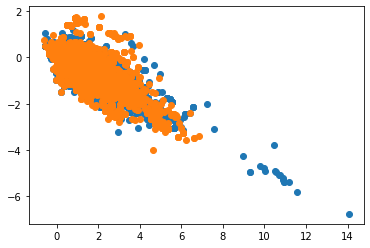

In [19]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

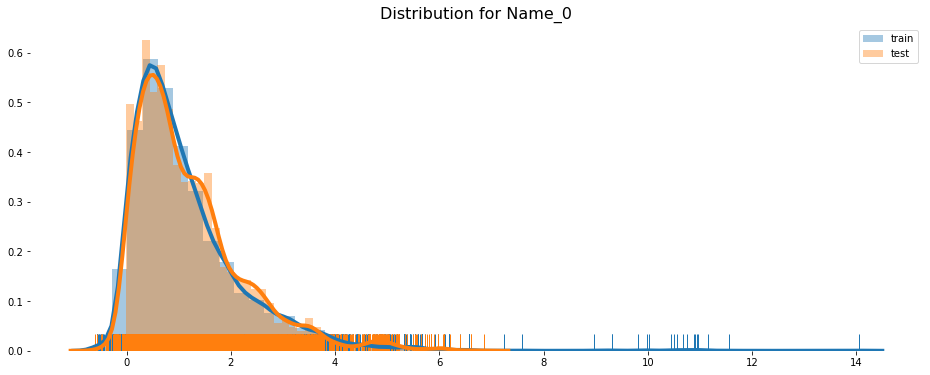

In [20]:
cols = 'Name_0'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Name_0'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Name_0'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

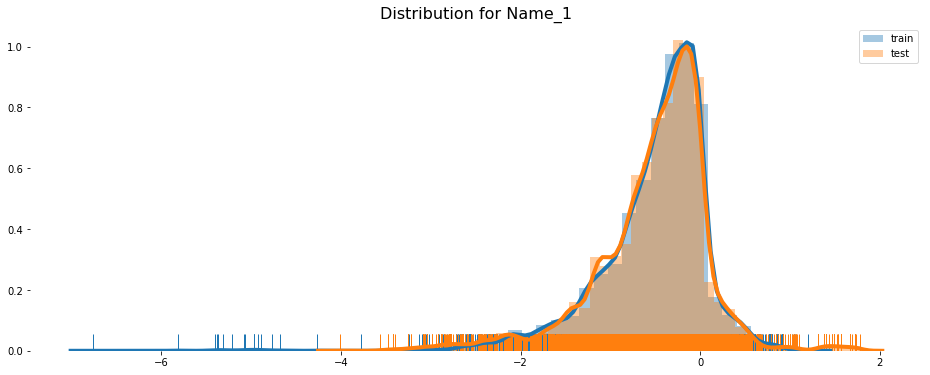

In [21]:
cols = 'Name_1'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Name_1'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Name_1'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

In [18]:
def translate_developer(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Publisher'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    pca = PCA(n_components=2)
    w_vec_pca = pca.fit_transform(w_vec)
    
    df['Developer_0'] = w_vec_pca[:, 0]
    df['Developer_1'] = w_vec_pca[:, 1]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [45]:
train_df_drop, test_df = translate_developer(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



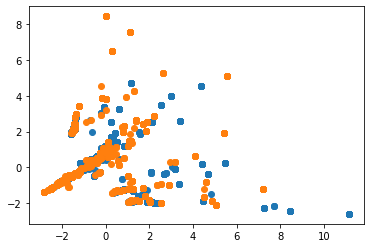

In [46]:
plt.scatter(train_df_drop['Developer_0'].values, train_df_drop['Developer_1'].values)
plt.scatter(test_df['Developer_0'].values, test_df['Developer_1'].values)

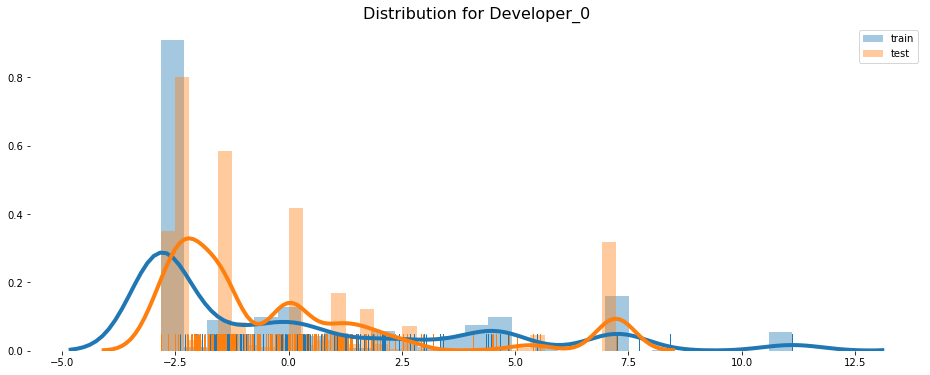

In [47]:
cols = 'Developer_0'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Developer_0'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Developer_0'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

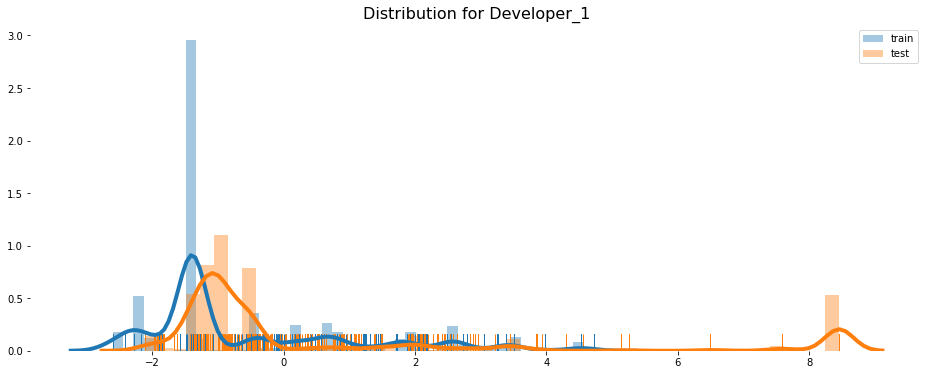

In [48]:
cols = 'Developer_1'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['Developer_1'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['Developer_1'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()

In [22]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Name_0,Name_1,...,Name_190,Name_191,Name_192,Name_193,Name_194,Name_195,Name_196,Name_197,Name_198,Name_199
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,2.255950,-1.228402,...,-0.208264,-3.675898,-0.278637,-1.128481,-1.674752,1.473212,-0.298637,-2.543966,0.265502,1.065758
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,3.374093,-1.642294,...,-0.332867,-5.125258,-0.736918,-1.075057,-0.797227,2.410554,-0.417196,-3.214041,0.571874,1.723033
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,2.255950,-1.228402,...,-0.208264,-3.675898,-0.278637,-1.128481,-1.674752,1.473212,-0.298637,-2.543966,0.265502,1.065758
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.275912,-0.123225,...,-0.114162,-0.379498,-0.139794,0.037900,-0.141308,0.342507,-0.081227,-0.198861,0.271266,0.285540
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,3.235529,-1.350131,...,-0.493970,-4.901072,0.226564,-1.212892,-0.365245,1.211463,-0.302164,-2.091394,0.264894,0.649774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,0.002429,0.001564,...,-0.001812,0.002095,-0.001459,0.000430,0.001229,-0.000836,0.001622,-0.002206,0.002358,-0.001491
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,0.730204,-0.233444,...,-0.259306,-1.796936,-0.289024,-0.568674,-0.820459,0.868285,-0.335908,-0.951145,1.214807,0.880588
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,0.858464,-0.384373,...,0.063813,-0.993056,-0.025813,-0.254538,-0.023074,0.773796,-0.074928,-0.885262,0.657424,0.036349
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,2.846423,-1.636288,...,-2.182119,-2.073681,-0.809465,0.967081,-1.372475,2.783975,0.168053,-1.281082,0.540261,2.433297


In [23]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [24]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [25]:


# kfoldの分割数
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
              "learning_rate": 0.05,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.634677	valid_0's rmse: 0.885523
[400]	training's rmse: 0.468555	valid_0's rmse: 0.869905
[600]	training's rmse: 0.368061	valid_0's rmse: 0.869425
[800]	training's rmse: 0.298906	valid_0's rmse: 0.870642
[1000]	training's rmse: 0.249431	valid_0's rmse: 0.871829
[1200]	training's rmse: 0.212372	valid_0's rmse: 0.873102
[1400]	training's rmse: 0.183102	valid_0's rmse: 0.875299
Early stopping, best iteration is:
[454]	training's rmse: 0.437325	valid_0's rmse: 0.868657
RMSLE_train: 0.4373249496697655, RMSLE_eval: 0.8686574518366104
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.634763	valid_0's rmse: 0.936722
[400]	training's rmse: 0.476803	valid_0's rmse: 0.917979
[600]	training's rmse: 0.374992	valid_0's rmse: 0.913753
[800]	training's rmse: 0.309447	valid_0's rmse: 0.914193
[1000]	training's rmse: 0.25986	valid_0's rmse: 0.913949
[1200]	training's rmse: 0.22237

In [26]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.9021789960785249


In [27]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof11.csv", index = False)

In [28]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [29]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub11.csv", index = False)

In [30]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

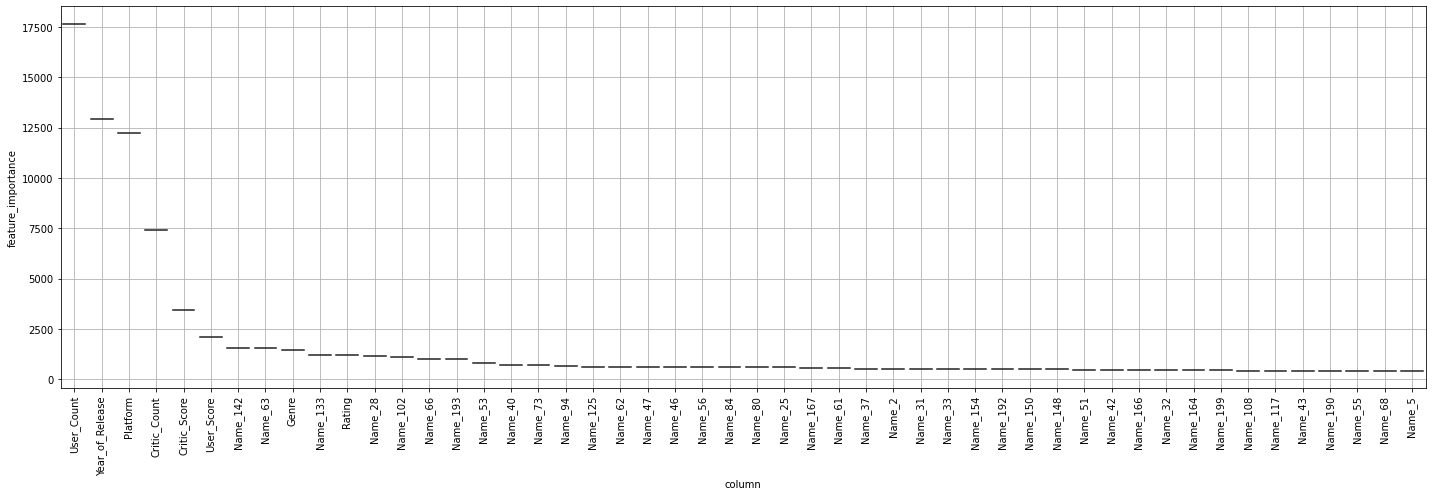

In [31]:
fig, ax = visualize_importance(model, X)


In [32]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Name_191,91.232448
Name_85,110.486851
Name_172,111.371531
Name_169,120.278014
Name_90,123.400453
...,...
Critic_Score,3440.039015
Critic_Count,7437.620066
Platform,12223.187741
Year_of_Release,12933.993592


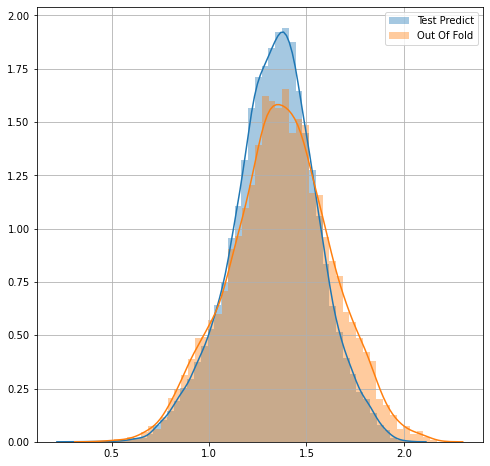

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()